This notebook demonstrates the network analysis utilized in PaySec.

* [Install packages](#Install-packages)


* [Clustering coefficient](#Clustering-coefficient)
    * [Import data and depict the network](#Import-data-and-depict-the-network)
    * [Calc Clustering coefficient](#Calc-Clustering-coefficient)
    * [Depicit a barchart of clustering coefficient](#Depicit-a-barchart-of-clustering-coefficient)
    * [Check outliers](#Check-outliers)
    
    
* [Community detection ](#Community-detection)
    * [Edge removing](#Edge-removing)
    * [Girvan-Newman heuristic algorithm](#Girvan-Newman-heuristic-algorithm)
    * [Find communities in graph](#Find-communities-in-graph)
    * [Detect isolated communities](#Detect-isolated-communities)
    * [Flag the nodes based on their neighbors' states (Fraudulent or Normal)](#Flag-the-nodes-based-on-their-neighbors'-states-(Fraudulent-or-Normal))

# Install packages

In [ ]:
!pip install networkx
!pip install matplotlib
!pip install numpy

# Clustering coefficient

The local clustering coefficient of a vertex (node) in a graph quantifies how close its neighbors are to being a clique (complete graph).

![caption](files/data/graph.png)

Attackers, who try to fraud, try to send spam numerously and randomly. As a result, their counterparties of transactions tend not to connect with each other. Then, the attackers' clustering coefficient tends to be low. We utilize this propensity for fraud detection. We confirm the clustering coefficients of each node and detect outliers that clustering coefficients are less than 2σ.

# Import data and depict the network

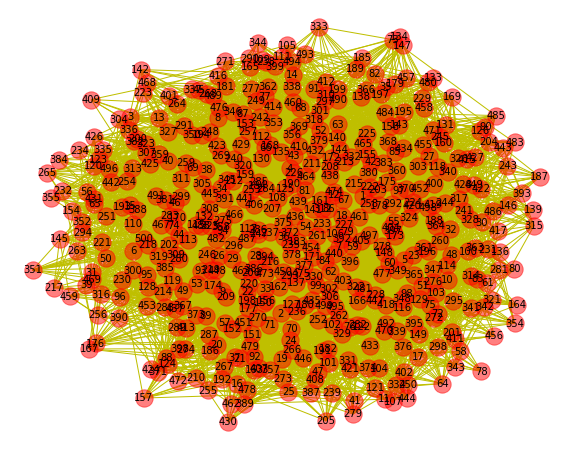

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
 
G = nx.read_edgelist('data/edgelist__.txt', nodetype=str)

#make figure
plt.figure(figsize=(10, 8))
 
#make layout
pos = nx.spring_layout(G, k=0.8)
 
#depict node and edge
#alpha: transparent level
nx.draw_networkx_edges(G, pos, edge_color='y')
nx.draw_networkx_nodes(G, pos, node_color='r', alpha=0.5)
 
#add node name
nx.draw_networkx_labels(G, pos, font_size=10)

plt.axis('off')
plt.show()

# Calculate Clustering coefficient

In [2]:
c = nx.clustering(G) 

In [3]:
print(c)

{'162': 0.023715415019762844, '110': 0.03676470588235294, '157': 0, '330': 0.031578947368421054, '247': 0.04, '280': 0.029411764705882353, '7': 0.029885057471264367, '153': 0.03684210526315789, '432': 0.03333333333333333, '386': 0.036231884057971016, '440': 0.051470588235294115, '152': 0.04743083003952569, '461': 0.043478260869565216, '437': 0.0380952380952381, '119': 0.023809523809523808, '264': 0.058823529411764705, '55': 0.038306451612903226, '171': 0.027586206896551724, '439': 0.006535947712418301, '380': 0.04093567251461988, '412': 0.06324110671936758, '315': 0.06666666666666667, '331': 0.06842105263157895, '317': 0.04666666666666667, '85': 0.06666666666666667, '75': 0.0380952380952381, '118': 0.04743083003952569, '448': 0.03557312252964427, '469': 0.03676470588235294, '403': 0.031578947368421054, '102': 0.05194805194805195, '139': 0.0641025641025641, '492': 0.02857142857142857, '438': 0.04329004329004329, '340': 0.029411764705882353, '92': 0.043478260869565216, '127': 0.047368421

# Depicit a barchart of clustering coefficient

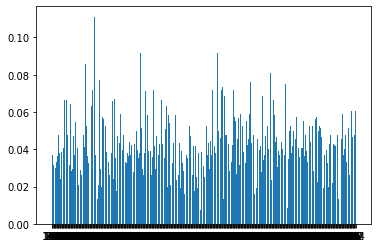

In [4]:
plt.bar(range(len(c)), list(c.values()), align='center')
plt.xticks(range(len(c)), list(c.keys()));

# Check outliers

In [5]:
import numpy as np
value = list(c.values())

dict_mean = np.mean(value)
dict_std = np.std(value)
threshold = dict_mean - 2 * dict_std

print("thereshold:{}".format(threshold))

thereshold:0.009498746457375702


In [6]:
outliers = [k for k, v in c.items() if v <= threshold ]
print(outliers)

['157', '439', '457', '243', '263', '279', '230', '334', '176', '217']


# Community detection 
In B2B transaction networks, there are many different network communities. 
Communities are groups of companies / corporate accounts. The transactions inside the communities are very frequent, and the entities within the same communities are highly connected. There are legitimate communities, but there are also fraudulent communities. 

Through community detection, we can detect fraudulent transactions in 2 ways:
If there are some isolated communities (e.g. <5 accounts/corporates in this community), it will be regarded as an unusual pattern in corporate operations because the actual number of entities involved must be much more than that. (Unless they are new to the transaction network!)
If we have flagged an account as ‘suspicious’, then other accounts in the same communities will be very possible to be flagged also. Because legitimate companies usually won’t have many transactions with fraudulent account, the companies within the same community are very likely to be also fraudsters. 

We use Girvan–Newman algorithm, which removes the edges that are most likely "between" communities over and over again until there are K (K is chosen beforehand) separate connected components appearing in the remaining network. These separate connected components are what we call communities.

We compute the betweenness value of each edge and then remove the edges in a decreasing order of betweenness value.
![caption](files/data/cluster.png)

# Edge removing

In [7]:
def edge_to_remove(graph):
    G_dict = nx.edge_betweenness_centrality(graph)
    edge = ()

  # extract the edge with highest edge betweenness centrality score
    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
          edge = key
          break

    return edge

# Girvan-Newman heuristic algorithm

Girvan-Newman algorithm deletes the edges that are most likely "between" communities over and over again, until there are separate connected components appearing in the remaining network. These separate connected components are what we call communities.

In [8]:
def girvan_newman(graph):
    # find number of connected components
    sg = nx.connected_components(graph)
    sg_count = nx.number_connected_components(graph)

    while(sg_count < 8):
        graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
        sg = nx.connected_components(graph)
        sg_count = nx.number_connected_components(graph)

    return sg

# Find communities in graph

In [9]:
#find communities in the graph
c = girvan_newman(G.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
    node_groups.append(list(i))

## Plot it! 

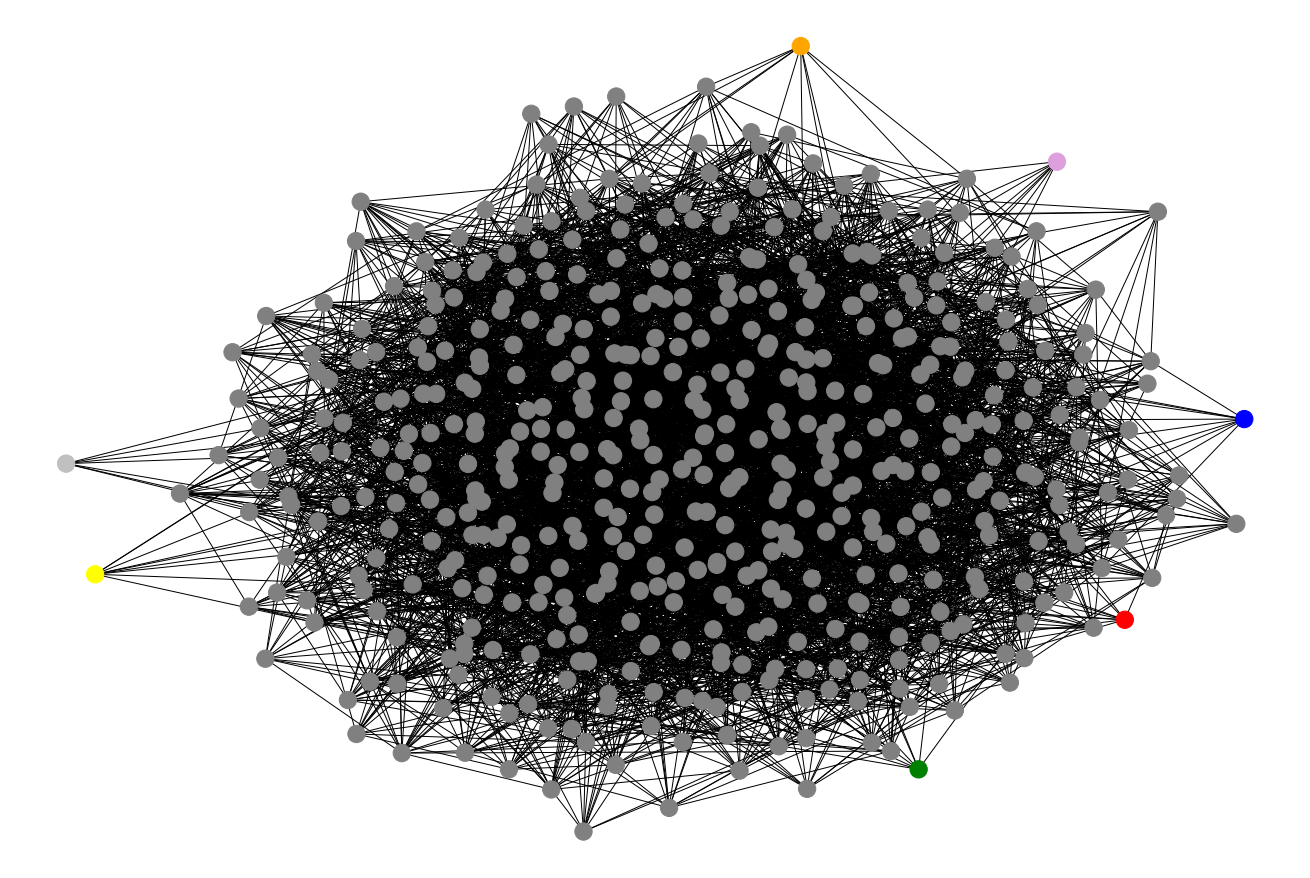

In [10]:
# plot the communities
color_map = []
for node in G:
    if node in node_groups[0]:
        color_map.append('grey')
    elif node in node_groups[1]: 
        color_map.append('green')
    elif node in node_groups[2]: 
        color_map.append('yellow')
    elif node in node_groups[3]: 
        color_map.append('red')
    elif node in node_groups[4]: 
        color_map.append('blue')
    elif node in node_groups[5]: 
        color_map.append('orange')
    elif node in node_groups[6]:
        color_map.append('silver')
    elif node in node_groups[7]:
        color_map.append('plum')
    else:
        color_map.append('brown')
        
        

        
#make figure
plt.figure(figsize=(18, 12))
 
#make layout
pos = nx.spring_layout(G)
 
#depict node and edge
# alpha: 透明度の指定
# nx.draw(G, pos, edge_color='y')
# nx.draw(G, pos, node_color='r', alpha=0.3)
 
#add node name
nx.draw(G, node_color=color_map, font_size=10)

plt.axis('off')
plt.show()
# nx.draw(G, node_color=color_map, with_labels=True)
# plt.show()


# Detect isolated communities

### There are 8 communities here. The gray one is the majority community while the other 7 communities only include 1 node. So we regard those "isolated" nodes as suspicious nodes here.

Let's then check the result consistency between this algorithm and the clustering coefficient calculation method.

In [11]:
test = {}
for i in outliers:
    for j in range(len(node_groups)):
        nodes_group = node_groups[j]
        if i in nodes_group:
            test[i] = j

Let's see where the outliers lie in the communities...

In [12]:
test

{'157': 0,
 '439': 0,
 '457': 1,
 '243': 0,
 '263': 0,
 '279': 0,
 '230': 0,
 '334': 4,
 '176': 0,
 '217': 5}

# Flag the nodes based on their neighbors' states (Fraudulent or Normal)

In [13]:
G.add_node(1000)
G.add_node(1001)
G.add_node(1002)
G.add_node(1003)
G.add_node(1004)

G.add_edges_from([[1001,'234'],[1003,'123'],[1002,'344'],[1000,'311'], [1004,'123'],  [1000, '206'], [1000,'384'],[1000, '355'],[1000, 1001], [1001, 1002], [1002,1003], [1003,1004], [1000,1003], [1001,1003]])



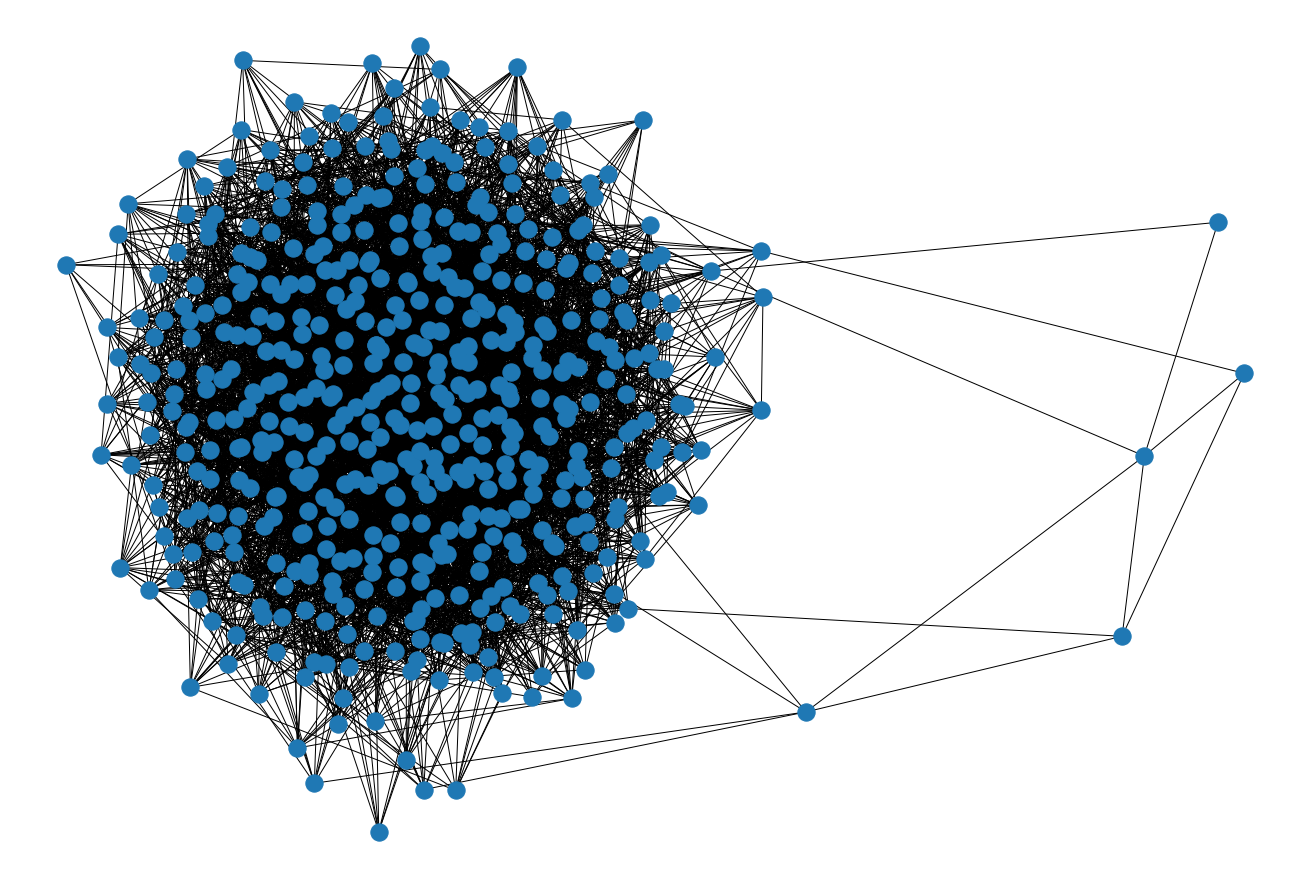

In [14]:
        
#make figure
plt.figure(figsize=(18, 12))
 
#make layout
pos = nx.spring_layout(G)


nx.draw(G, font_size=10)

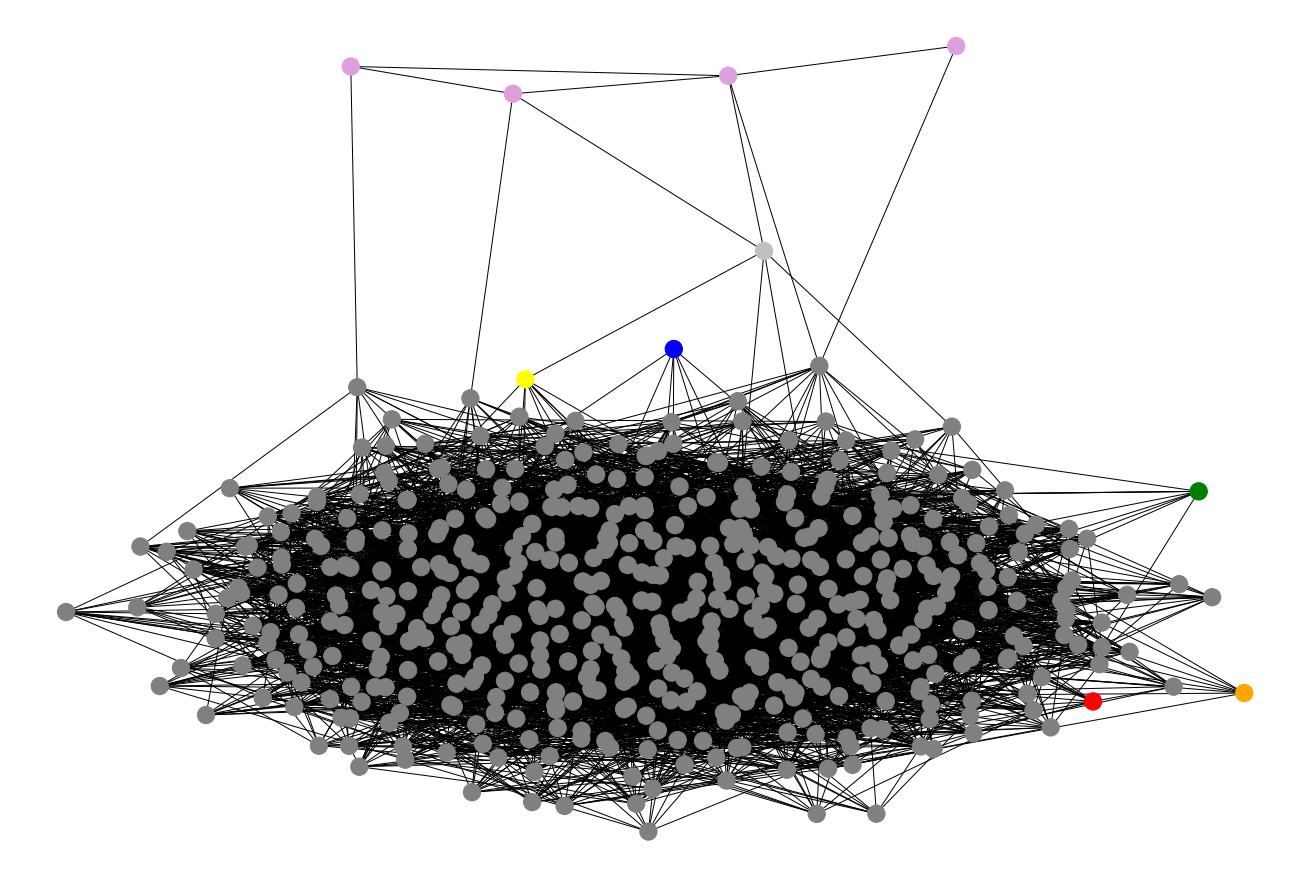

In [15]:
#find communities in the graph
c = girvan_newman(G.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
    node_groups.append(list(i))

# plot the communities
color_map = []
for node in G:
    if node in node_groups[0]:
        color_map.append('grey')
    elif node in node_groups[1]: 
        color_map.append('green')
    elif node in node_groups[2]: 
        color_map.append('yellow')
    elif node in node_groups[3]: 
        color_map.append('red')
    elif node in node_groups[4]: 
        color_map.append('blue')
    elif node in node_groups[5]: 
        color_map.append('orange')
    elif node in node_groups[6]:
        color_map.append('silver')
    elif node in node_groups[7]:
        color_map.append('plum')
    else:
        color_map.append('brown')
        

#make figure
plt.figure(figsize=(18, 12))
 
#make layout
pos = nx.spring_layout(G)
 
#depict node and edge
# alpha: 透明度の指定
# nx.draw(G, pos, edge_color='y')
# nx.draw(G, pos, node_color='r', alpha=0.3)
 
#add node name
nx.draw(G, node_color=color_map, font_size=10)

plt.axis('off')
plt.show()
# nx.draw(G, node_color=color_map, with_labels=True)
# plt.show()


### If one of the 4 pink nodes (on the right) is proved to be a fraudulent entity, we will also flag the other 3 nodes as highly suspicious nodes.

# Reference


[1] https://www.geeksforgeeks.org/clustering-coefficient-graph-theory/